## BBA 1451 landing pages performance
Hypothesis: there are highly converting landing pages

Results: homepages have the highest traffic share and add-to-basktet rate while PDP pages have the lowest traffic share and highest bounce rate

Data used: ON, 2019-03

Note: bounce defined as the sessions with a time on site less than 3 seconds

In [2]:
import re
import os, sys
from plotting.plotting import *
import matplotlib.gridspec as GridSpec
from bigquery_api.connector import BigQuery
%matplotlib inline
plt.style.use('bsestyle_light')

In [4]:
df_raw = pd.read_csv('hao_landingpage_final.csv')
print df_raw.head()

                    session_code              cg    ToS  pages  plps  pdps  \
0  15527299535362077069235157278  Organic Search   45.0      1   198     0   
1  15524899976033421169637006861     Paid Search   83.0      5   148     0   
2  15525100804992637765025361024          Direct    NaN      1     4     0   
3  15520669122046845650909440352          Direct    NaN      1     4     0   
4  15518214524749839505685394390     Paid Search  363.0      5   402    11   

                               page_list  \
0                                    plp   
1  homepage,plp,homepage,search,homepage   
2                                    plp   
3                                    plp   
4                    plp,pdp,pdp,pdp,pdp   

                                          event_list  
0        Pagination,Pagination,Pagination,Pagination  
1                     Service Bar,Service Bar,Filter  
2                                                NaN  
3                                             

### Cleaning data &  feature

In [5]:
# create columns with the first/second page/event in the list.
def get_second(x):
    l = len(x.split(','))
    if l > 1:
        a = x.split(',')[1-l]
    else: 
        a = 'null'
    return a 

def tag_total_atb(string):
    i=0
    str_list = string.split(',')
    for x in str_list:
        
        if x == 'Add to Cart':
            i+=1
    return i

df = df_raw.copy()
df.ToS.fillna(0,inplace=True)                                          # time on site if null then 0
df.page_list.fillna('null',inplace=True)                               # page list if null then string "null"
df.event_list.fillna('null',inplace=True)                              # event list if null then string "null"
df.page_list = df.page_list.apply(lambda x: x.replace('selector,','')) # ignore selector as a landing page
df.page_list = df.page_list.apply(lambda x: x.replace('CLP','plp'))    

df['landing_page'] = df.page_list.apply(lambda x: x.split(',')[0])     # first page
df['second_page'] = df.page_list.apply(get_second)                     # second page
df['first_event'] = df.event_list.apply(lambda x: x.split(',')[0])     # first event
df['total_atb'] = df.event_list.apply(tag_total_atb)                   # total add to basket
df['is_atb'] = np.where(df.total_atb>0,1,0)                            # tag if add to basket
df['is_bounce'] = np.where(df.ToS <3,1,0)                              # defined bounce as impatient user (time on site < 3s)
print df.head()

                    session_code              cg    ToS  pages  plps  pdps  \
0  15527299535362077069235157278  Organic Search   45.0      1   198     0   
1  15524899976033421169637006861     Paid Search   83.0      5   148     0   
2  15525100804992637765025361024          Direct    0.0      1     4     0   
3  15520669122046845650909440352          Direct    0.0      1     4     0   
4  15518214524749839505685394390     Paid Search  363.0      5   402    11   

                               page_list  \
0                                    plp   
1  homepage,plp,homepage,search,homepage   
2                                    plp   
3                                    plp   
4                    plp,pdp,pdp,pdp,pdp   

                                          event_list landing_page second_page  \
0        Pagination,Pagination,Pagination,Pagination          plp        null   
1                     Service Bar,Service Bar,Filter     homepage         plp   
2                      

In [7]:
# create a light version of data frame for further use
df_light = df.drop(['pages','page_list','event_list'],axis=1)
df_light['session_code'] = 1                                            # session_code not needed, assign 1 for easier count
df_light.loc[df_light.second_page=='search','first_event'] = 'Search'   # search not tracked as event, manually adjust
df_light.loc[df_light.cg=='Transactional_Emails','cg'] = 'Trans. Emails'# shorten name
print df_light.head()

   session_code              cg    ToS  plps  pdps landing_page second_page  \
0             1  Organic Search   45.0   198     0          plp        null   
1             1     Paid Search   83.0   148     0     homepage         plp   
2             1          Direct    0.0     4     0          plp        null   
3             1          Direct    0.0     4     0          plp        null   
4             1     Paid Search  363.0   402    11          plp         pdp   

   first_event  total_atb  is_atb  is_bounce  
0   Pagination          0       0          0  
1  Service Bar          0       0          0  
2         null          0       0          1  
3         null          0       0          1  
4       Filter          0       0          0  


#### Bounce - impatient user

In [11]:
df_light1.cg.unique()

array(['Organic Search', 'Paid Search', 'Direct', 'Email',
       'Google Shopping', 'Affiliates', 'Retargeting', 'Referral',
       '(Other)', 'Trans. Emails', 'Social', 'Display'], dtype=object)

In [12]:
df_light1 = df_light.copy()
df_light1.loc[df_light1.cg.isin(cg_list1)==False,'cg']='Other'
df_light1.cg.unique()

array(['Organic Search', 'Paid Search', 'Direct', 'Email',
       'Google Shopping', 'Affiliates', 'Other'], dtype=object)

In [13]:
cg_list1 = ['Paid Search', 'Direct', 'Organic Search', 'Email', 'Google Shopping', 'Affiliates', 'Other']
cg_list2 = ['Paid Search', 'Direct', 'Organic Search', 'Email', 'Google Shopping', 'Affiliates', 
           'Retargeting', 'Referral', 'Trans. Emails', 'Social', 'Display', '(Other)']


In [39]:
def get_kpi(df,group,kpi):
    # used for different level of grouping and different kpis  
    df_sub = df.groupby(group)[['session_code','is_bounce','is_atb']].sum()
    df_sub['pct_bounce'] = df_sub.is_bounce*1.0 / df_sub.session_code
    df_sub['pct_atb'] = df_sub.is_atb*1.0 / df_sub.session_code
    df_sub['pct_session'] = df_sub.session_code*1.0 / df_sub.session_code.sum()
    df_sub = df_sub.loc[['homepage','plp','pdp']]
    
    if len(group) == 2:
        df_sub_kpi = df_sub[kpi].unstack(0).reindex(cg_list1)[['homepage','plp','pdp']]
    elif len(group) == 1:
        df_sub_kpi = df_sub[kpi]
    return df_sub_kpi

def plot(df,ax,ylabel,title,rot=0):
    #plot individual plots
    labels = df.index.tolist()
    quick_bar(df,ax,ylabel=ylabel,title=title)
    if type(df)==pd.core.series.Series:
        ax.set_xticks(np.arange(len(labels)))
    else:
        ax.set_xticks(np.arange(len(labels))+0.25)
    ax.set_xticklabels(labels,rotation=rot)
    ax.set_ylim(0,ax.get_ylim()[-1]*1.2)
    ax.legend(loc=1,ncol=3)

def plot_overview(df,kpi1,kpi2):
    # plot entile graph
    keyword = 'Bounce' if kpi1 =='pct_bounce' else 'ATB'
    
    fig = plt.figure(figsize=(12.6,4.8),dpi=120)

    gs = GridSpec.GridSpec(2,4) 

    ax1 = fig.add_subplot(gs[0,:1])
    df_plot = get_kpi(df,['landing_page'],kpi1)
    plot(df_plot,ax1,ylabel=keyword+' Rate [%]',title='Landing Page '+keyword+' Rate [%]')
        
    ax2 = fig.add_subplot(gs[0,1:])
    df_plot = get_kpi(df,['landing_page','cg'],kpi1) 
    plot(df_plot,ax2,ylabel=keyword+' Rate [%]',title='Landing Page '+keyword+' Rate [%]',rot=30)

        
    ax3 = fig.add_subplot(gs[1,:1])
    df_plot = get_kpi(df,['landing_page'],kpi2)
    plot(df_plot,ax3,ylabel='Session Share [%]',title='Landing Page Session Share [%]')

    ax4 = fig.add_subplot(gs[1,1:])
    df_plot = get_kpi(df,['landing_page','cg'],kpi2)
    plot(df_plot,ax4,ylabel='Session Share [%]',title='Landing Page Session Share [%]',rot=30)

    plt.tight_layout()
    plt.show()

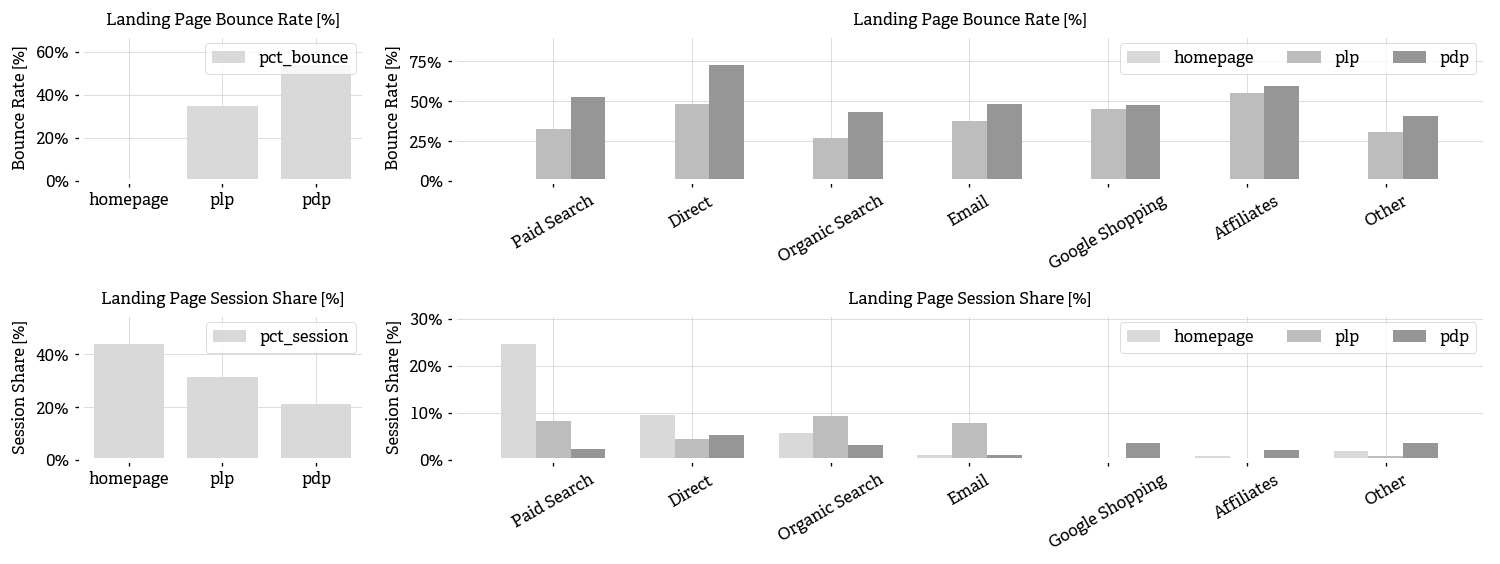

In [29]:
plot_overview(df_light1,'pct_bounce','pct_session')

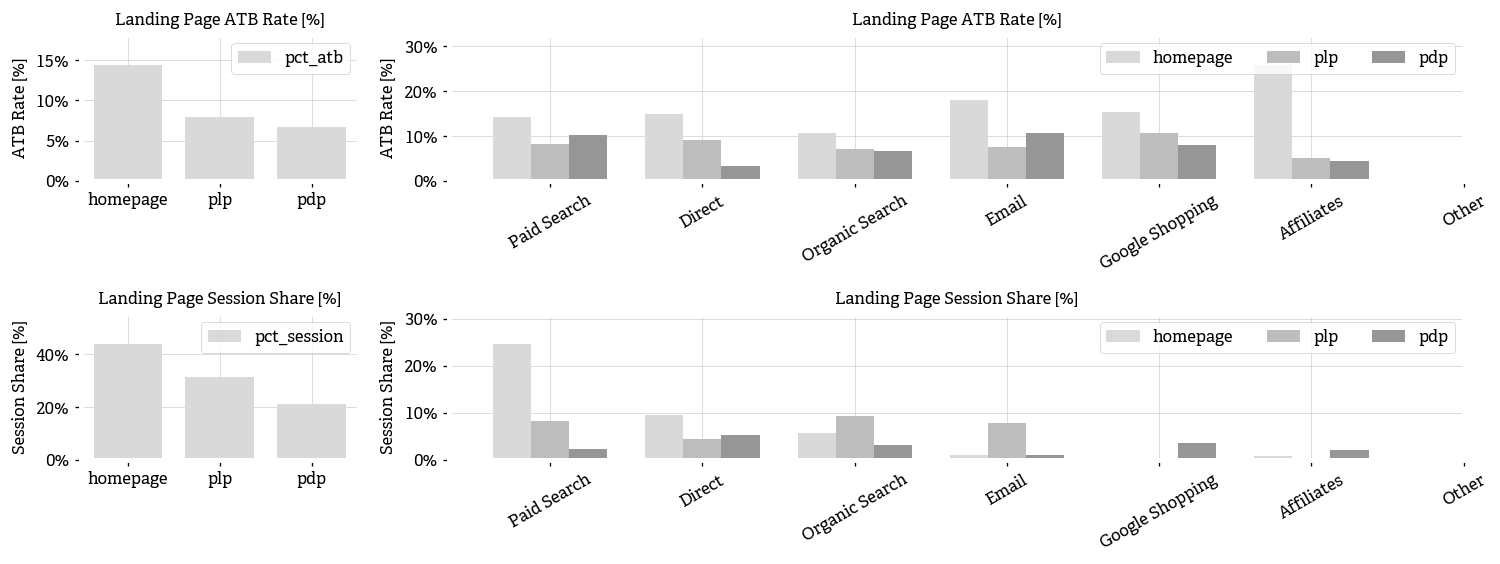

In [30]:
plot_overview(df_light1,'pct_atb','pct_session')

* Homepage has significant lower bounce rate
* Homepage has the highest traffic share and add to basket rate in all channel groupings
* PDP pages have the lowes traffic share and highest bounce rate in all channel groupings
* 'bounce' as total time on site < 3 seconds

#### Excluding bounce

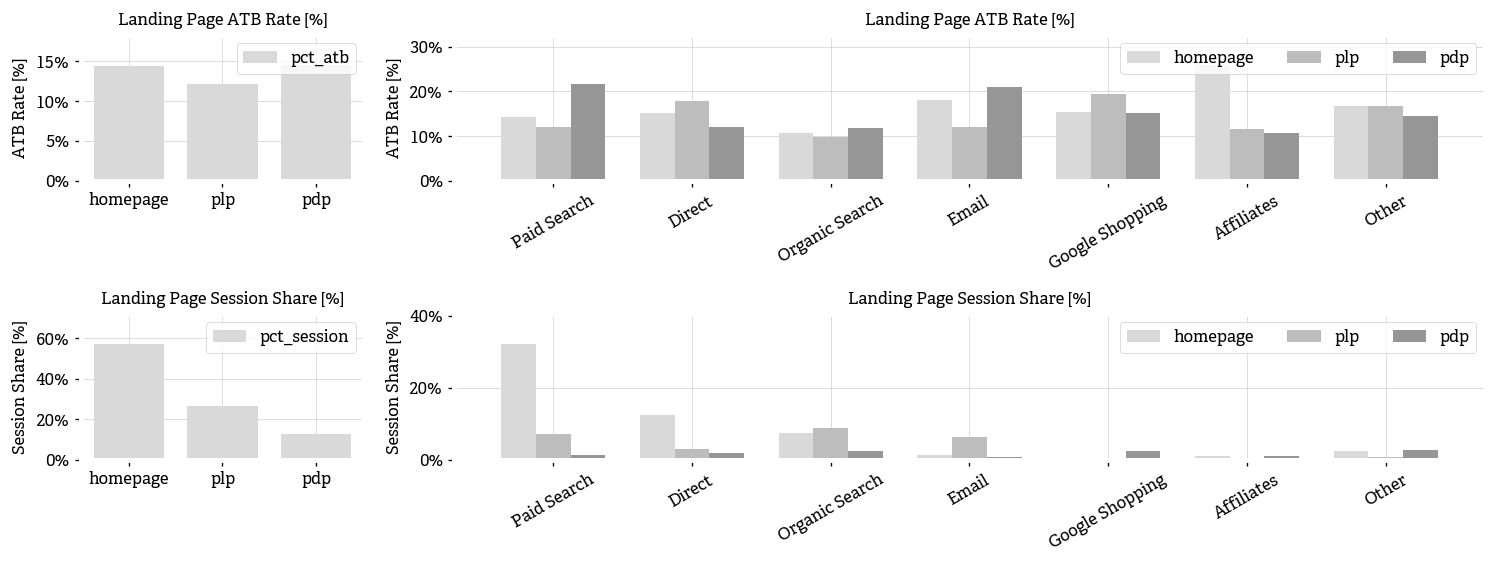

In [32]:
df_light_clean = df_light1.loc[df_light1.ToS>=3,:]
plot_overview(df_light_clean,'pct_atb','pct_session')

* If exclude bounce sessions, pdp pages have a more or less similar atb rate compared with the other two (don't know if this helps)

In [37]:
df_light_clean2 = df_light.loc[df_light1.ToS>=3,:]
df_light_lp = df_light_clean2.groupby(['landing_page','cg']).agg({'session_code':'sum', # total nr sessions
                                                                 'plps':'mean',        # avg product viewed per session
                                                                 'pdps':'mean',        # avg product detail viewed per session
                                                                 'total_atb':'mean'})  # avg nr product add to basket per session
df_light_lp = df_light_lp.sort_values(by='session_code',ascending=True)
print df_light_lp.head()

                             total_atb  plps  session_code  pdps
landing_page cg                                                 
other        Display               0.0  30.0             1  18.0
shipping     Display               2.0   0.0             1   6.0
selector     Social                0.0  16.0             1   0.0
             Organic Search        0.0   0.0             1   3.0
revieworder  Social                0.0   0.0             1   0.0


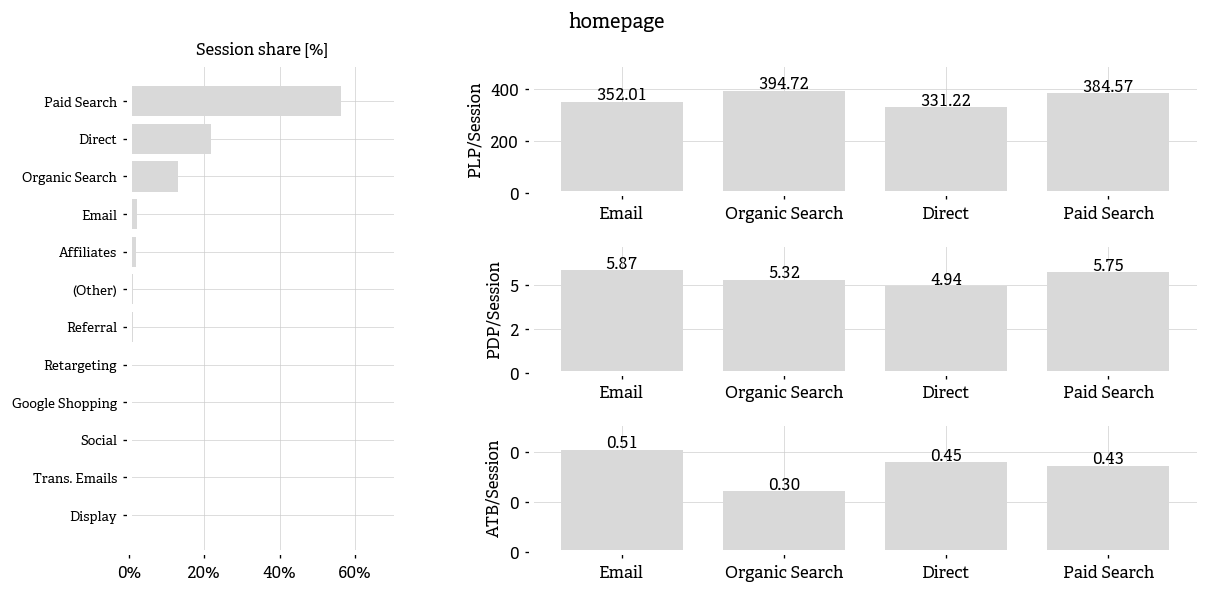

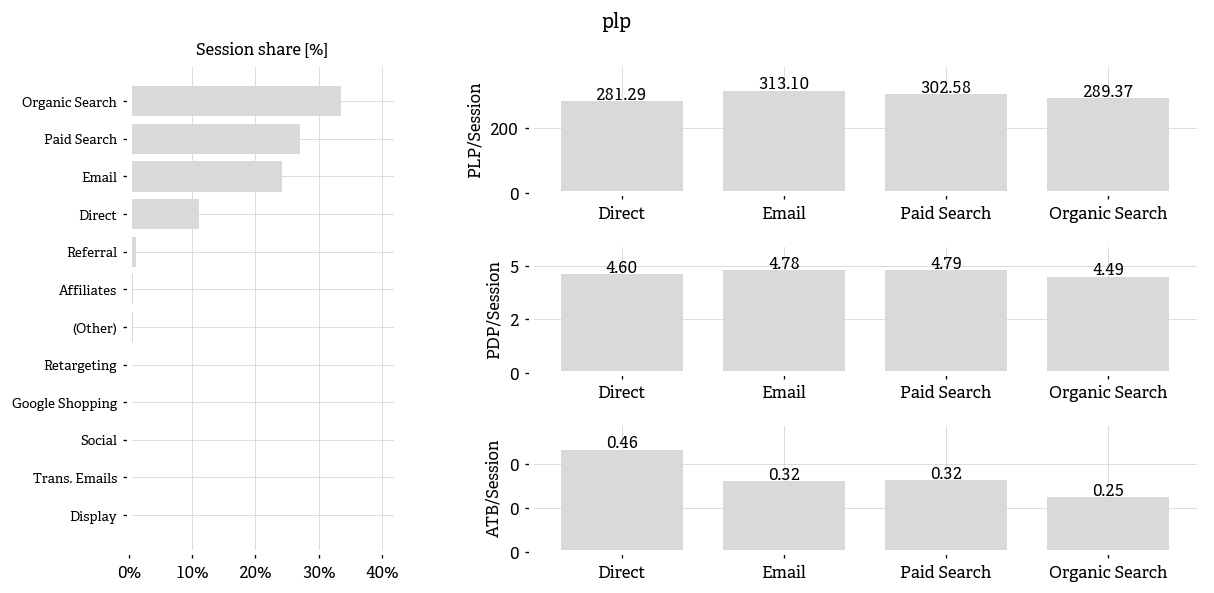

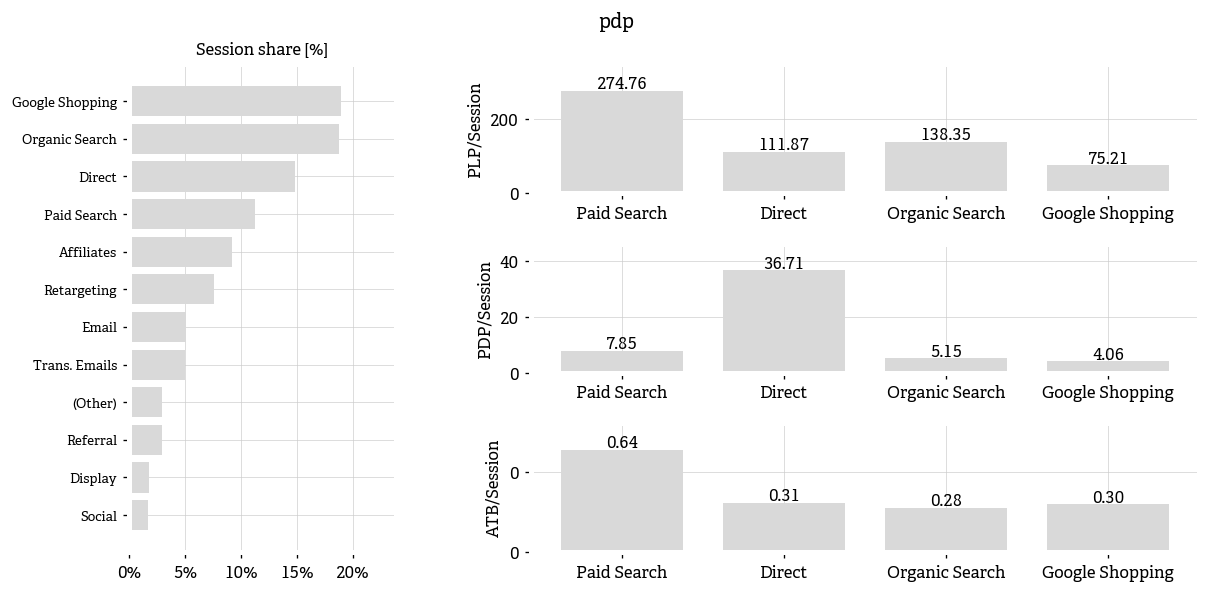

In [40]:
for landing_page in ['homepage','plp','pdp']:
    # landing page session share%
    df_lp = df_light_lp.loc[landing_page]
    df_lp_pct = df_lp*1.0/df_lp.sum()

    fig = plt.figure(figsize=(12.6,4.8),dpi=120)
    gs = GridSpec.GridSpec(3, 4)
    ax1 = plt.subplot(gs[0:,1])
    ax2 = plt.subplot(gs[0, 2:])
    ax3 = plt.subplot(gs[1, 2:])
    ax4 = plt.subplot(gs[2, 2:])

    y = np.arange(len(df_lp_pct))
    ax1.barh(y,df_lp_pct['session_code'])
    ax1.set_yticks(y)
    ax1.set_yticklabels(df_lp_pct.index.tolist(),fontsize=8)
    ax1.set_xlim(0,ax1.get_xlim()[-1]*1.2)
    ax1.set_title('Session share [%]')
    format_x_values(ax1,'%')
    
    # top channel grouping performance in terms of avg plp/pdp/atb
    top_cg = df_lp.tail(4).sort_values(by='session_code').index.tolist() # top channel groupings per landing page
    
    df_lp_cg = df_lp.loc[top_cg]
    quick_bar(df_lp_cg['plps'],ax2,ylabel='PLP/Session',legend=False)
    quick_bar(df_lp_cg['pdps'],ax3,ylabel='PDP/Session',legend=False)
    quick_bar(df_lp_cg['total_atb'],ax4,ylabel='ATB/Session',legend=False)
    for ax in [ax2,ax3,ax4]:
        ax.set_ylim(0,ax.get_ylim()[-1]*1.2)
        ax.set_xticks(np.arange(len(df_lp_cg)))
        ax.set_xticklabels(df_lp_cg.index.tolist())
        format_y_values(ax,',')
        add_bar_labels(ax,format=',',precision=2,spacing=0.05)
    plt.suptitle(landing_page,x=0.6,y=1.02)
    plt.tight_layout()
    plt.show()

### Fun fact: top 3 user event per landing page

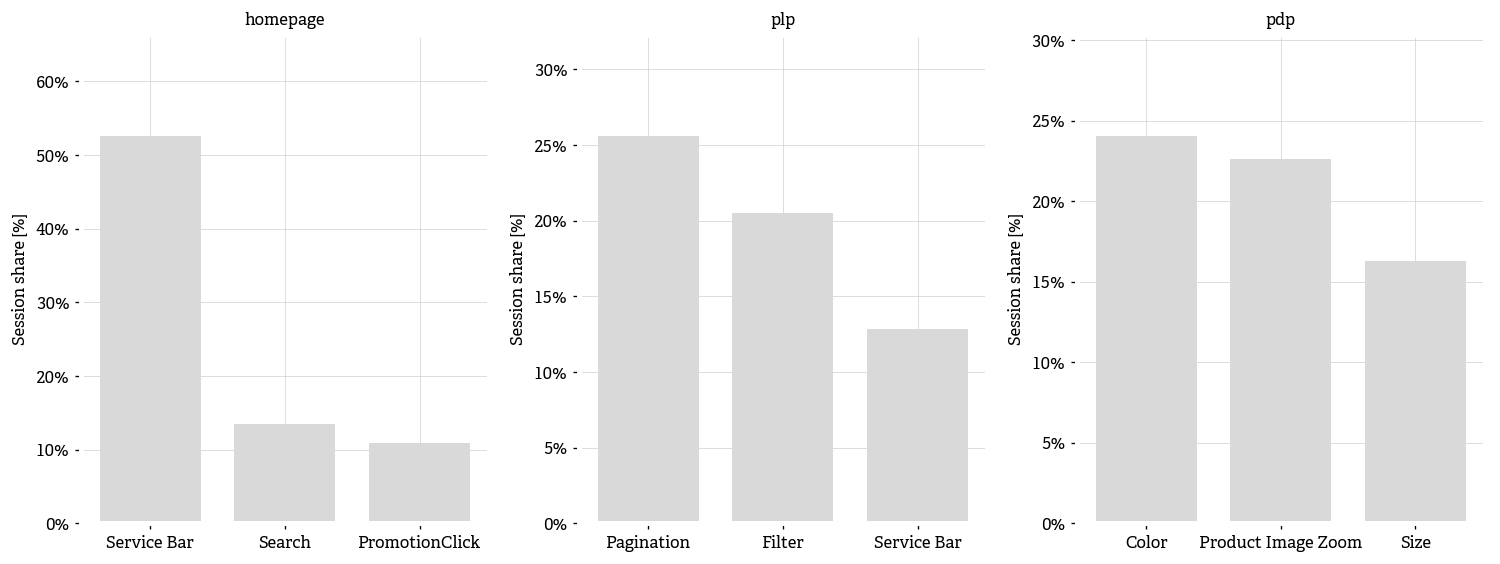

In [41]:
df_event = df_light_clean.groupby(['landing_page','first_event'])['session_code'].sum()
lp_list=['homepage','plp','pdp']
fig = plt.figure(figsize=(12.6,4.8),dpi=120)

for i, lp in enumerate(lp_list,1):
    
    ax = fig.add_subplot(1,3,i)
    df_lp_event = df_event.loc[lp].sort_values(ascending=False)
    df_lp_event_pct =(df_lp_event*1.0/df_lp_event.sum()).head(3)
    labels=df_lp_event_pct.index.tolist()
    quick_bar(df_lp_event_pct,ax,legend=False)
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(labels,rotation=0)
    ax.set_ylim(0,ax.get_ylim()[-1]*1.2)
    ax.set_title(lp)
    ax.set_ylabel('Session share [%]')
    
plt.tight_layout()
plt.show()